Time Series Analysis

In [1]:
# Importing the libraries
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

set_seed(455)
np.random.seed(455)


In [2]:
# Specify the path to the CSV file
#csv_file = "data/Mastercard_stock_history.csv"


# Read the CSV file into a DataFrame, specifying the index and parsing dates
dataset = pd.read_csv("Desktop/TSLA.csv", index_col="Date", parse_dates=["Date"])

# Print the first few rows of the dataset
print(dataset.head())

                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


In [3]:
print(dataset.describe())

              Open         High          Low        Close    Adj Close  \
count  2416.000000  2416.000000  2416.000000  2416.000000  2416.000000   
mean    186.271147   189.578224   182.916639   186.403651   186.403651   
std     118.740163   120.892329   116.857591   119.136020   119.136020   
min      16.139999    16.629999    14.980000    15.800000    15.800000   
25%      34.342498    34.897501    33.587501    34.400002    34.400002   
50%     213.035004   216.745002   208.870002   212.960007   212.960007   
75%     266.450012   270.927513   262.102501   266.774994   266.774994   
max     673.690002   786.140015   673.520020   780.000000   780.000000   

             Volume  
count  2.416000e+03  
mean   5.572722e+06  
std    4.987809e+06  
min    1.185000e+05  
25%    1.899275e+06  
50%    4.578400e+06  
75%    7.361150e+06  
max    4.706500e+07  


In [4]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


In [6]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

In [7]:
target = 'High'

In [8]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist() if col != target and col != target)

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


Outlier Detection

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2.5 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

Indices of outliers: [   0    1    2  125  191  666  692  718  720  723  724  731  734  735
  766  812  846  916  917  920  921 1164 1752 2041 2042 2078 2098 2226
 2236 2238 2250 2283 2347 2348 2385 2386 2387 2388 2389 2390 2391 2392
 2393 2394 2395 2396 2397 2398 2399 2400 2402 2405 2407 2409 2410 2411
 2413 2414 2415]
Details of outliers:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29   19.000000   25.000000   17.540001   23.889999   23.889999   
2010-06-30   25.790001   30.420000   23.299999   23.830000   23.830000   
2010-07-01   25.000000   25.920000   20.270000   21.959999   21.959999   
2010-12-27   28.020000   28.580000   25.059999   25.549999   25.549999   
2011-03-31   26.549999   28.709999   26.500000   27.750000   27.750000   
2013-02-21   36.490002   37.389999   34.540001   35.160000   35.160000   
2013-04-01   42.360001   46.680000   41.700001   43.930000   43.9

In [10]:
# Extract the first date
first_date = dataset.index[0]
tstart = first_date.replace(year=first_date.year).strftime('%Y-%m-%d')

# Calculate the 60th percentile of the data
quantile_date = dataset.index[int(len(dataset) * 0.7)]
tend = quantile_date.replace(year=quantile_date.year).strftime('%Y-%m-%d')

print("tstart:", tstart)
print("tend:", tend)

tstart: 2010-07-02
tend: 2017-02-16


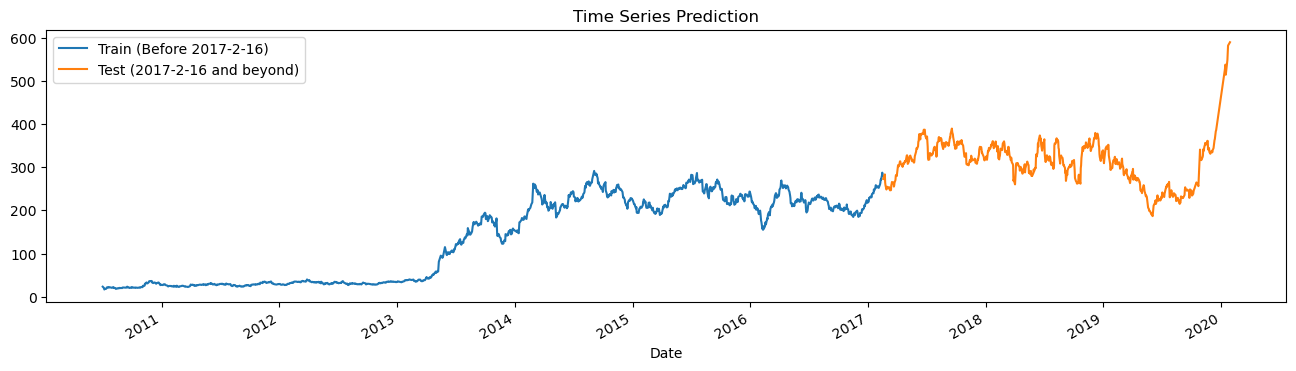

In [11]:
tstart_year = 2010
tstart_month = 7
tstart_day = 2

tend_year = 2017
tend_month = 2
tend_day = 16

def train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    dataset.loc[tstart:tend, target].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].plot(figsize=(16, 4), legend=True)
    
    plt.legend([f"Train (Before {tend})", f"Test ({tend} and beyond)"])
    plt.title("Time Series Prediction")
    plt.show()

train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [12]:
def train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    train = dataset.loc[tstart:tend, target].values
    test = dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].values
    
    return train, test

training_set, test_set = train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [13]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [14]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [15]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

LSTM Model

In [16]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=256, activation="relu", input_shape=(n_steps, features)))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(units=128, activation="relu"))
model_lstm.add(Dropout(0.05))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/Users/jennawilson/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,217 (1.13 MB)

 Trainable params: 297,217 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0610
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0064
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0035
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0033
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0031
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0025
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0022
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0020
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0019
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0018
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - lo

Results

In [18]:
dataset_total = dataset.loc[:,target]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_target = model_lstm.predict(X_test)
#inverse transform the values
predicted_target = sc.inverse_transform(predicted_target)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [19]:
def plot_predictions(test, predicted_target):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted_target, color="red", label="Predicted")
    plt.title("Time Series Prediction")
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.legend()
    plt.show()


def return_rmse(test, predicted_target):
    rmse = np.sqrt(mean_squared_error(test, predicted_target))
    print("The root mean squared error is {:.2f}.".format(rmse))


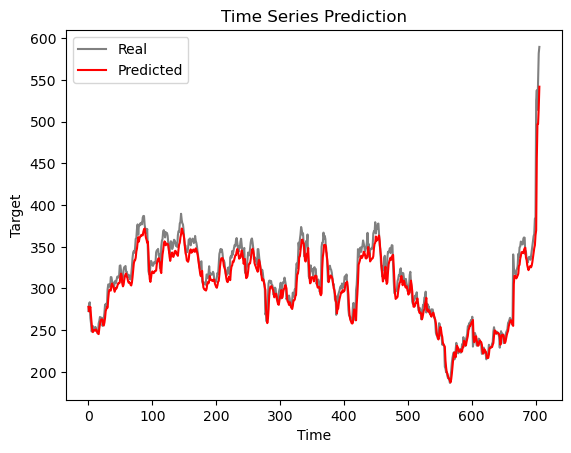

In [20]:
plot_predictions(test_set,predicted_target)

In [21]:
return_rmse(test_set,predicted_target)

The root mean squared error is 14.50.
